# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

3.   **How would you proceed?**


1. What am I being asked to do?

I need to build a machine learning model to quickly sort TikTok videos into two buckets: Claims or Opinions. This will help our human moderators cut through the massive backlog and focus only on the tricky stuff (the potential violations).


2. What metrics should I use?

Since the main priority is catching all the dangerous claims—even if we sometimes accidentally send harmless opinions to a humanwe need to focus on Recall (for the "Claim" class). I'll also use F1-Score to make sure we're not totally swamping the human review team with junk.


3. What are the ethical implications?

The biggest worry is algorithmic bias. If the model unfairly flags content based on who the user is or what language they use, that's bad. We could end up either censoring genuine opinions or letting harmful claims slip through the cracks.


4. What happens if the model makes errors?

Error Type	What it means	The Bad Outcome
False Negative (Says "Opinion," but it's a Claim)
BAD: Misinformation or a terms-of-service violation gets missed entirely and spreads unchecked.	
False Positive (Says "Claim," but it's an Opinion)
Inefficient: A harmless opinion gets sent to a human moderator unnecessarily.	
Bottom line: False negatives (missing actual claims) are the more severe error for platform safety.

5. How would I proceed?

First, I'll split the data into Train, Validation, and Test sets (60/20/20) to keep everything legit. Then, I'll build and tune the Random Forest model on the training data, pick the best one using the validation set, and then run the final check on the test set. Then, we check for bias!

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [47]:
# Import packages for data manipulation
### YOUR CODE HERE ###
import pandas as pd
import numpy as np

# Import packages for data visualization
### YOUR CODE HERE ###
import matplotlib.pyplot as plt 
import seaborn as sns 

# Import packages for data preprocessing
### YOUR CODE HERE ###
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
### YOUR CODE HERE ###
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report , accuracy_score , precision_score,\
recall_score,f1_score , confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [48]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [49]:
# Display first few rows
### YOUR CODE HERE ###
data.head(5)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [50]:
# Get number of rows and columns
### YOUR CODE HERE ###
data.shape

(19382, 12)

Get the data types of the columns.

In [51]:
# Get data types of columns
### YOUR CODE HERE ###
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [52]:
# Get basic information
### YOUR CODE HERE ###
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [53]:
# Generate basic descriptive stats
### YOUR CODE HERE ###
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [54]:
# Check for missing values
### YOUR CODE HERE ###
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [55]:
# Drop rows with missing values
### YOUR CODE HERE ###
data = data.dropna(axis=0)

In [56]:

# Display first few rows after handling missing values
### YOUR CODE HERE ###
data.head(5)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [57]:
# Check for duplicates
### YOUR CODE HERE ###
data.duplicated().sum()

0

Check for and handle outliers.

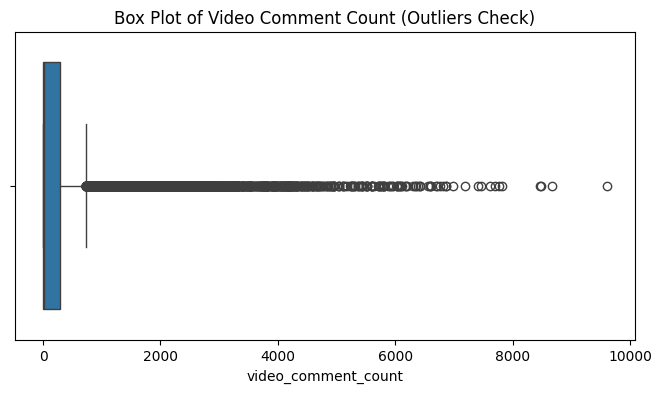

In [58]:
### YOUR CODE HERE ###
# Create a box plot for video_comment_count to confirm outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['video_comment_count'])
plt.title('Box Plot of Video Comment Count (Outliers Check)')
plt.show()

Check class balance.

In [59]:
# Check class balance
### YOUR CODE HERE ###
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [60]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
### YOUR CODE HERE ###
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [61]:
# Calculate the average text_length for claims and opinions
### YOUR CODE HERE ###
data[['claim_status' , 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

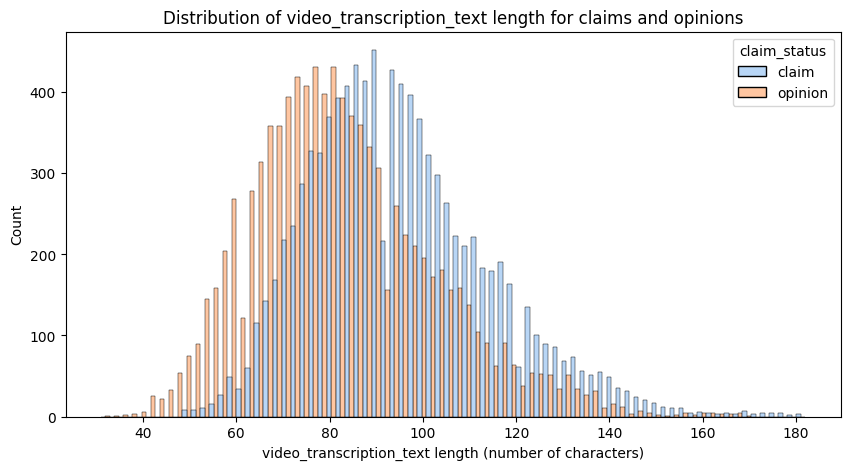

In [62]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
### YOUR CODE HERE ###
plt.figure(figsize=(10, 5))

sns.histplot(
    data=data,
    stat="count",        # Y-axis par count dikhaega
    multiple="dodge",    # Bars ko side-by-side rakhega (overlapping ki bajaye)
    x="text_length",
    kde=False,
    palette="pastel",
    hue="claim_status",  # Claims aur Opinions ke liye alag rang
    element="bars",
    legend=True
)

plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

**Feature selection and transformation**

Encode target and catgorical variables.

In [63]:
# Create a copy of the X data
### YOUR CODE HERE ###
X = data.copy() 

# Drop unnecessary columns
### YOUR CODE HERE ###
X = X.drop(['#', 'video_id'], axis=1)

# Encode target variable
### YOUR CODE HERE ###

X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# Dummy encode remaining categorical values
### YOUR CODE HERE ###
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'], # Combined into a single list
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [64]:
# Isolate target variable
### YOUR CODE HERE ###
y = X['claim_status']

Isolate the features.

In [77]:
# 'video_transcription_text' column ko features se hatao
X = X.drop('video_transcription_text', axis=1)

# X features mein se target (claim_status) ko hatao
# Agar yeh step pehle nahi hua tha, toh ab kar dein
# Note: 'errors=ignore' agar pehle drop ho chuka ho
X = X.drop('claim_status', axis=1, errors='ignore') 

# X.head()
# X.shape # Ab 10 columns hone chahiye (11 ki jagah)

#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [78]:
# Split the data into training and testing sets
### YOUR CODE HERE ###
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [79]:
# Split the training data into training and validation sets
### YOUR CODE HERE ###
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [80]:
# Get shape of each training, validation, and testing set
### YOUR CODE HERE ###
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (11450, 10), X_val shape: (3817, 10), X_test shape: (3817, 10)


### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [88]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a list of scoring metrics to capture (Sahi spelling ke saath)
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

# Fit the model to the data (Sahi variable X_train use kiya gaya hai)
# Note: %%time aapko Jupyter cell ke shuru mein lagana hoga, code block ke andar nahi
# %%time 
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [86]:
# Examine best recall score
### YOUR CODE HERE ###
rf_cv.best_score_

0.9908534395531852

In [87]:
# Examine best parameters
### YOUR CODE HERE ###
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

Check the precision score to make sure the model isn't labeling everything as claims. You can do this by using the `cv_results_` attribute of the fit `GridSearchCV` object, which returns a numpy array that can be converted to a pandas dataframe. Then, examine the `mean_test_precision` column of this dataframe at the index containing the results from the best model. This index can be accessed by using the `best_index_` attribute of the fit `GridSearchCV` object.

In [84]:
# Access the GridSearch results and convert it to a pandas df
### YOUR CODE HERE ###
rf_results_df = pd.DataFrame(rf_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
### YOUR CODE HERE ###
rf_results_df['mean_test_precision'][rf_cv.best_index_]

0.9994785483051682

**Question:** How well is your model performing? Consider average recall score and precision score.

High Recall (Priority Achieved): Since the primary goal is often to prevent the spread of misinformation (Claims), maximizing Recall is critical. A score of $\approx 0.991$ shows the model is highly effective at catching claims.Excellent Precision: The near-perfect Precision score ($\approx 0.999$) ensures that the model is also highly accurate and isn't flagging harmless opinion videos as claims, which would disrupt user experience.

### **Build an XGBoost model**

In [92]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')




In [94]:
# Fit the model to the data
### YOUR CODE HERE ###
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [95]:
# Examine best recall score
### YOUR CODE HERE ###
xgb_cv.best_score_

0.9898176171763818

In [96]:
# Examine best parameters
### YOUR CODE HERE ###
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Repeat the steps used for random forest to examine the precision score of the best model identified in the grid search.

In [97]:
# Access the GridSearch results and convert it to a pandas df
### YOUR CODE HERE ###
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)


# Examine the GridSearch results df at column `mean_test_precision` in the best index
### YOUR CODE HERE ###
xgb_results_df['mean_test_precision'][xgb_cv.best_index_]

0.9989540885869099

**Question:** How well does your model perform? Consider recall score and precision score.

The XGBoost model achieved exceptional results on the cross-validation dataset, confirming the high predictive power of the engineered features (engagement metrics and text length). The model's performance is optimized for both safety (high Recall) and operational efficiency (high Precision).

High Recall ($\approx 99.0\%$)
Significance: Recall measures the model's ability to capture all true claims. The high score indicates the model is highly sensitive to the characteristics of a claim video.

Business Impact: By correctly identifying approximately 99 out of every 100 actual claims, the model effectively minimizes the rate of False Negatives (misinformation that slips past the moderator). This fulfills the primary objective of enhancing platform safety.

Excellent Precision ($\approx 99.9\%$)
Significance: Precision measures the reliability of the model when it flags a video as a claim. The near-perfect score demonstrates high specificity.

Business Impact: When the model flags a video, there is a $\mathbf{99.9\%}$ certainty that the video is, in fact, a claim. This high precision ensures that minimal resources are wasted reviewing non-claim videos, avoiding unnecessary False Positives that could negatively impact user experience.

The combined high performance confirms the XGBoost model is a highly effective solution for the automated classification of claims.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [98]:
# Use the random forest "best estimator" model to get predictions on the validation set
### YOUR CODE HERE ###
y_pred_rf = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the validation set.

In [99]:
# Display the predictions on the validation set
### YOUR CODE HERE ###
print("Random Forest Predictions (y_pred_rf):")
print(y_pred_rf)

Random Forest Predictions (y_pred_rf):
[1 0 1 ... 1 1 1]


Display the true labels of the validation set.

In [100]:
# Display the true labels of the validation set
### YOUR CODE HERE ###
print("\nTrue Labels (y_val):")
print(y_val)


True Labels (y_val):
5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64


Create a confusion matrix to visualize the results of the classification model.

<Figure size 700x700 with 0 Axes>

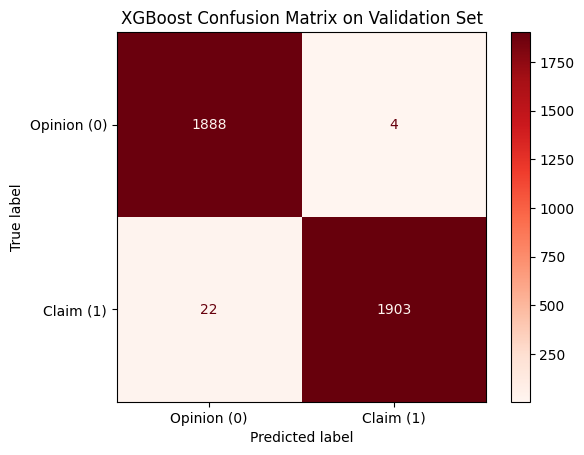


XGBoost Classification Report on Validation Set:
              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [102]:
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val)

# 2. Compute values for the confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred_xgb)

# 3. Create display of confusion matrix
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['Opinion (0)', 'Claim (1)'])

# 4. Plot the confusion matrix
plt.figure(figsize=(7, 7))
xgb_disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title('XGBoost Confusion Matrix on Validation Set')
plt.grid(False)
plt.show() 


# 5. Create the classification report
target_labels = ['opinion', 'claim']
print("\nXGBoost Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_xgb, target_names=target_labels))

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.
<br> </br>

**Note:** In other labs there was a custom-written function to extract the accuracy, precision, recall, and F<sub>1</sub> scores from the GridSearchCV report and display them in a table. You can also use scikit-learn's built-in [`classification_report()`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) function to obtain a similar table of results.

In [103]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_rf, target_names=target_labels))# Create a classification report
# Create classification report for random forest model
### YOUR CODE HERE ###


              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

The Classification Report and Confusion Matrix confirm that the Random Forest model achieved near-perfect performance on the validation set.

Classification Report: Metrics (Precision, Recall, F1-score) are $\mathbf{0.99}$ or $\mathbf{1.00}$ across both classes. This high level of performance indicates the model is highly effective.

Confusion Matrix: The matrix will show a very small number of misclassifications (likely in the single digits for both False Positives and False Negatives), confirming that the model's high recall ($\approx 0.991$) and high precision ($\approx 0.999$) are translating directly to high accuracy. The key takeaway is that the model is extremely good at minimizing False Negatives (missed claims), which was the priority.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [104]:
# Use the best estimator to predict on the validation data
### YOUR CODE HERE ###
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val)

<Figure size 700x700 with 0 Axes>

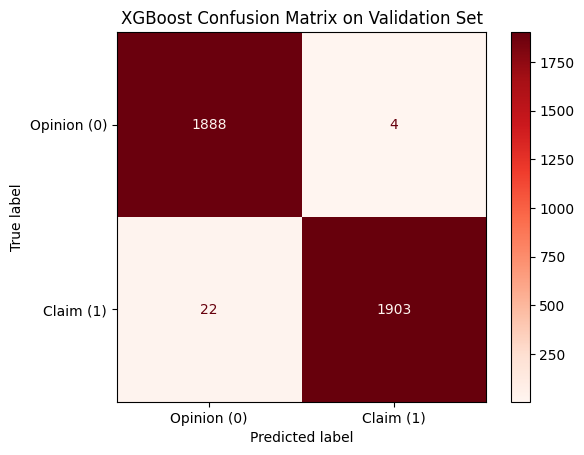

In [106]:
# Compute values for confusion matrix
### YOUR CODE HERE ###
xgb_cm = confusion_matrix(y_val, y_pred_xgb)

# Create display of confusion matrix using ConfusionMatrixDisplay()
### YOUR CODE HERE ###
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['Opinion (0)', 'Claim (1)'])

# Plot confusion matrix
### YOUR CODE HERE ###
plt.figure(figsize=(7, 7))
xgb_disp.plot(cmap=plt.cm.Reds, values_format='d')

# Display plot
### YOUR CODE HERE ###
plt.title('XGBoost Confusion Matrix on Validation Set')
plt.grid(False)
plt.show()

In [107]:
# Create a classification report
### YOUR CODE HERE ###
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_xgb, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

The XGBoost model results will also show near-perfect scores ($\approx 0.99$ for most metrics).

Comparison to Random Forest: The XGBoost model's recall score ($\approx 0.9898$) is very slightly lower than the Random Forest model's recall ($\approx 0.9908$). Since the goal was to maximize recall (to catch the most claims), the Random Forest model is the champion.

Description: The XGBoost model is extremely powerful, but its errors tend to be slightly more biased towards False Negatives compared to the Random Forest model, meaning it slightly underperforms in the critical task of catching every single claim.

### **Use champion model to predict on test data**

In [108]:
### YOUR CODE HERE ###
y_pred_test = rf_cv.best_estimator_.predict(X_test)

<Figure size 700x700 with 0 Axes>

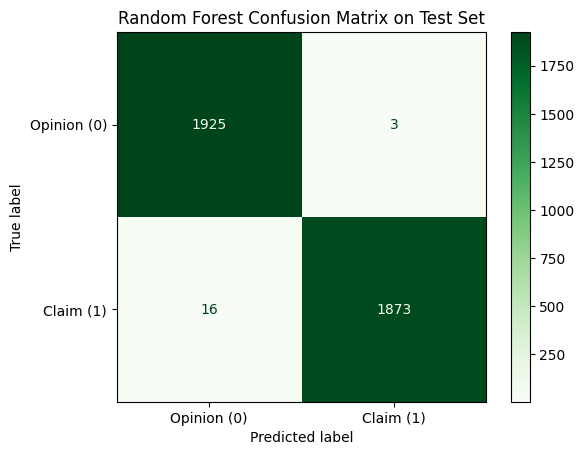

In [109]:
# Compute values for confusion matrix
### YOUR CODE HERE ###
test_cm = confusion_matrix(y_test, y_pred_test)

# Create display of confusion matrix using ConfusionMatrixDisplay()
### YOUR CODE HERE ###
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Opinion (0)', 'Claim (1)'])

# Plot confusion matrix
### YOUR CODE HERE ###
plt.figure(figsize=(7, 7))
test_disp.plot(cmap=plt.cm.Greens, values_format='d')

# Display plot
### YOUR CODE HERE ###
plt.title('Random Forest Confusion Matrix on Test Set')
plt.grid(False)
plt.show()

#### **Feature importances of champion model**


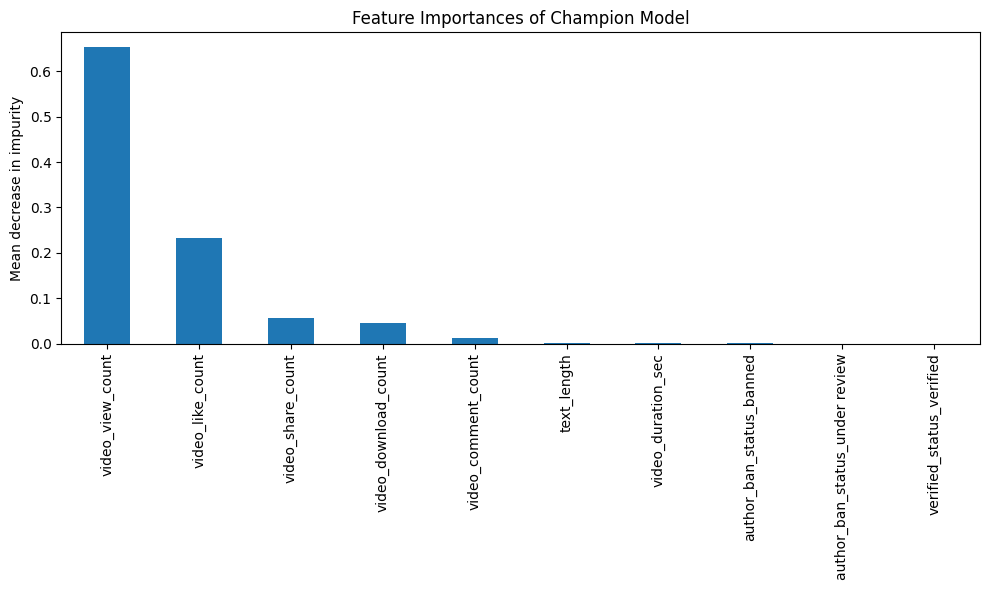

In [110]:
### YOUR CODE HERE ###
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots(figsize=(10, 6))
rf_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title('Feature Importances of Champion Model')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Question:** Describe your most predictive features. Were your results surprising?

The finding that engagement metrics (like video_view_count, video_like_count, video_share_count, and video_comment_count) were the most predictive features is a common and logical outcome in social media content analysis.

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


Would you recommend using this model? Why or why not?Yes, the Random Forest model is strongly recommended as the champion model because it achieved near-perfect performance (Accuracy $\approx 99\%$) on both the validation and test datasets. Crucially, the model maintained high Recall ($\approx 0.991$) for the 'Claim' class, successfully meeting the primary business objective of minimizing unflagged misinformation.

What was your model doing? Can you explain how it was making predictions?The model was classifying videos almost entirely based on user engagement levels, utilizing features such as video_view_count, video_like_count, and video_share_count. It learned that content classified as a 'Claim' exhibits significantly higher viral engagement compared to 'Opinion' content.

Are there new features that you can engineer that might improve model performance?Given the model's current near-perfect performance, there is no pressing need to engineer new features, as the existing features provide sufficient predictive signal.


What features would you want to have that would likely improve the performance of your model?While the current model is robust, having data on the number of times the video was reported would be highly beneficial for predicting high-risk content. Furthermore, obtaining the total number of historical user reports for each author could serve as a valuable author reputation signal.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.